In [1]:
from pathlib import Path
import os
import sys

sys.path.append(str(Path(os.getcwd()).parent))

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
import tensorflow as tf
from typing import Any

In [3]:
table_regression = pd.read_csv('../data/regression.csv', parse_dates=['Accident Date/Time', 'Shutdown Date/Time', 'Restart Date/Time'])
table_classification = pd.read_csv('../data/classification.csv', parse_dates=['Service Start Date', 'Service End Date'])

In [4]:
table_regression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2795 entries, 0 to 2794
Data columns (total 43 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Report Number                         2795 non-null   int64         
 1   Supplemental Number                   2795 non-null   int64         
 2   Accident Year                         2795 non-null   int64         
 3   Accident Date/Time                    2795 non-null   datetime64[ns]
 4   Operator ID                           2795 non-null   int64         
 5   Operator Name                         2795 non-null   object        
 6   Pipeline/Facility Name                2674 non-null   object        
 7   Pipeline Location                     2795 non-null   object        
 8   Liquid Type                           2795 non-null   object        
 9   Liquid Subtype                        1349 non-null   object        
 10  

In [5]:
table_classification.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14628 entries, 0 to 14627
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               14628 non-null  int64         
 1   Development Name    14628 non-null  object        
 2   Borough             14628 non-null  object        
 3   Account Name        14628 non-null  object        
 4   Location            962 non-null    object        
 5   Meter Scope         22 non-null     object        
 6   TDS #               14628 non-null  int64         
 7   EDP                 14628 non-null  int64         
 8   RC Code             14628 non-null  object        
 9   Funding Source      13106 non-null  object        
 10  AMP #               12490 non-null  object        
 11  Vendor Name         14628 non-null  object        
 12  UMIS BILL ID        14628 non-null  int64         
 13  Revenue Month       14628 non-null  object    

# Визуализация данных

In [6]:
plt.style.use('seaborn-v0_8')

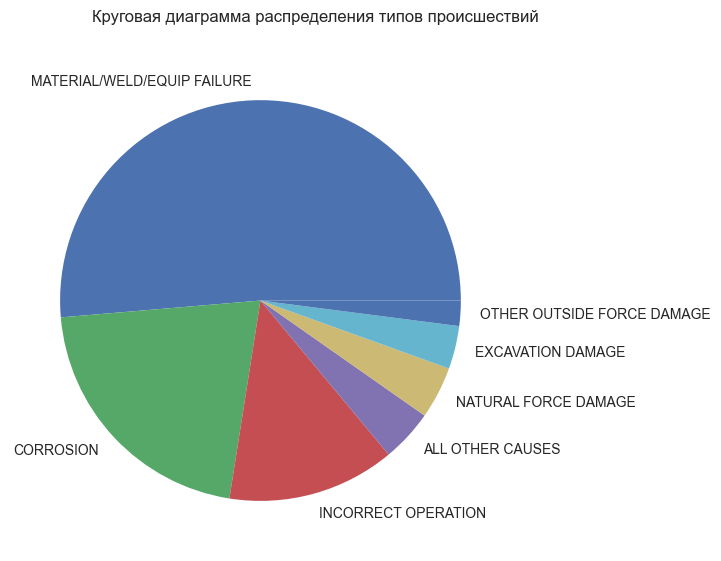

In [7]:
# Круговая диаграмма распределения типов происшествий

fig, axs = plt.subplots(constrained_layout=True)
fig.suptitle('Круговая диаграмма распределения типов происшествий\n')

info = table_regression.value_counts('Cause Category')

axs = plt.pie(info, labels=info.index)

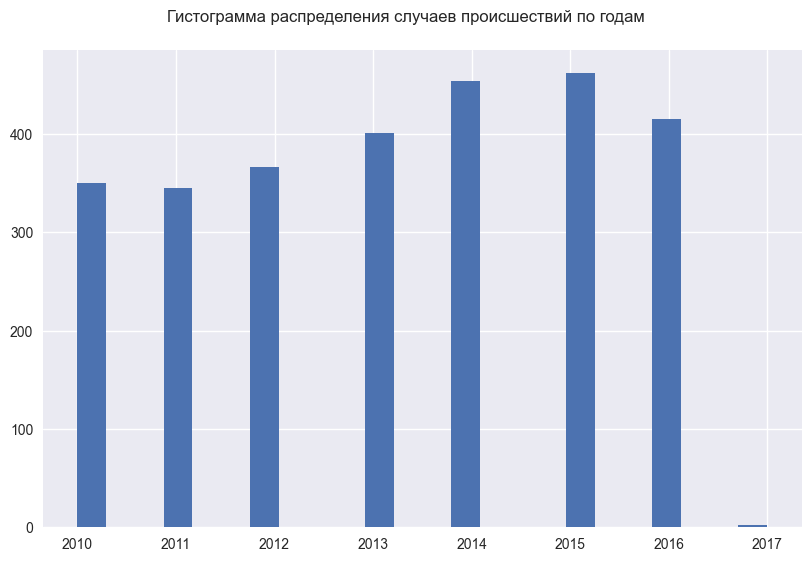

In [8]:
# Гистограмма распределения случаев происшествий по годам

fig, axs = plt.subplots(constrained_layout=True)
fig.suptitle('Гистограмма распределения случаев происшествий по годам\n')

axs = plt.hist(table_regression["Accident Year"], bins=24)

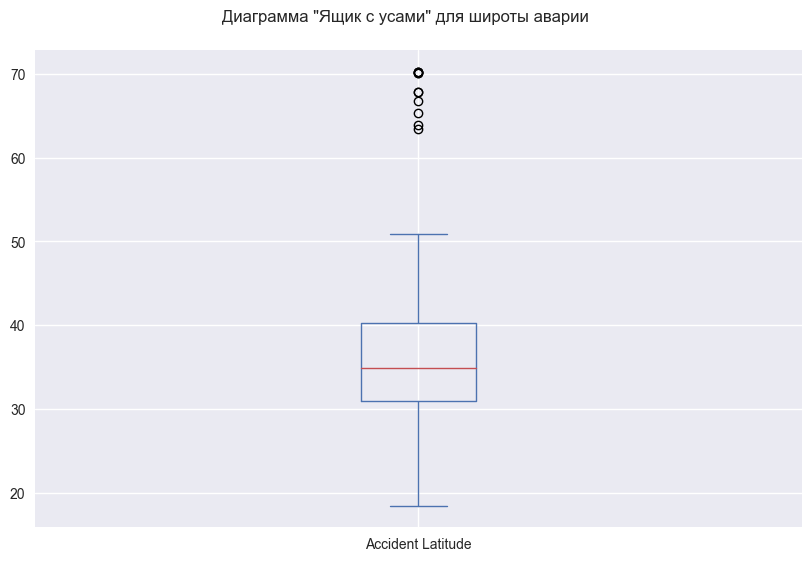

In [9]:
# Диаграмма "Ящик с усами" для широты аварии

fig, axs = plt.subplots(constrained_layout=True)
fig.suptitle('Диаграмма "Ящик с усами" для широты аварии\n')

axs = table_regression['Accident Latitude'].plot(kind="box", x=table_regression['Accident Latitude'])

C:\Users\bugae\AppData\Local\Temp\ipykernel_21272\3959970203.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  axs = sns.heatmap(table_regression.corr())


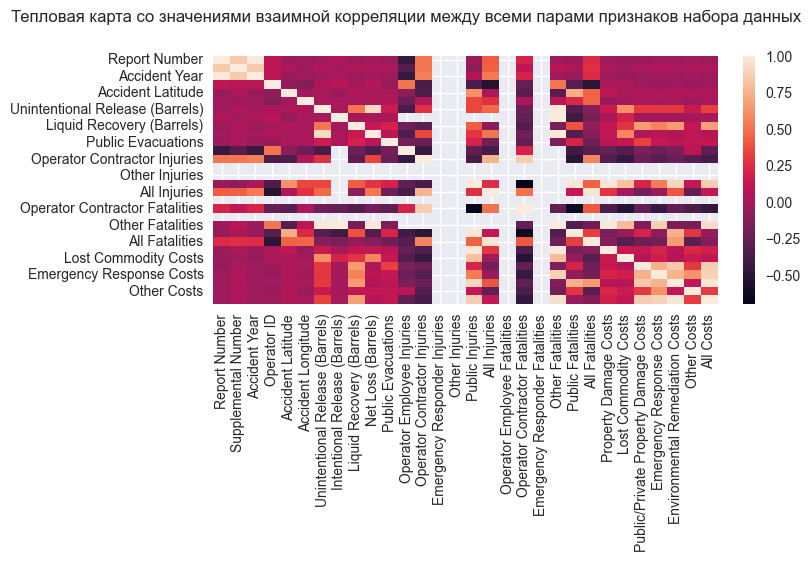

In [10]:
# Тепловая карта со значениями взаимной корреляции между всеми парами признаков набора данных

fig, axs = plt.subplots(constrained_layout=True)
fig.suptitle('Тепловая карта со значениями взаимной корреляции между всеми парами признаков набора данных\n')

axs = sns.heatmap(table_regression.corr())

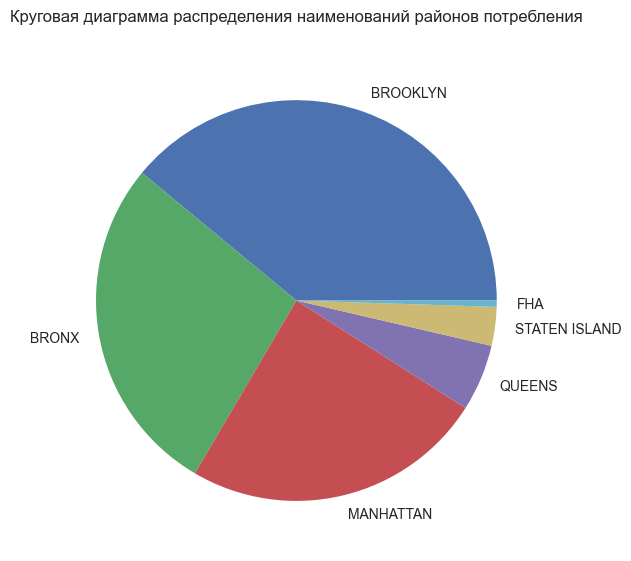

In [11]:
# Круговая диаграмма распределения наименований районов потребления

fig, axs = plt.subplots(constrained_layout=True)
fig.suptitle('Круговая диаграмма распределения наименований районов потребления\n')

info = table_classification.value_counts('Borough')

axs = plt.pie(info, labels=info.index)

# Предобработка данных таблицы для регрессии

In [12]:
# 1. Выполним анализ столбиков таблицы для регрессии.
# 1.1 Посмотрим список всех столбцов таблицы. Удалим из таблицы поля, содержащие уникальные значения (похожие на id) и малоинформативные

table_regression.drop(columns=['Report Number', 'Supplemental Number', 'Operator ID', 
                               'Operator Name', 'Pipeline/Facility Name'], axis=1, inplace=True)

In [13]:
table_regression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2795 entries, 0 to 2794
Data columns (total 38 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Accident Year                         2795 non-null   int64         
 1   Accident Date/Time                    2795 non-null   datetime64[ns]
 2   Pipeline Location                     2795 non-null   object        
 3   Liquid Type                           2795 non-null   object        
 4   Liquid Subtype                        1349 non-null   object        
 5   Liquid Name                           222 non-null    object        
 6   Accident Latitude                     2795 non-null   float64       
 7   Accident Longitude                    2795 non-null   float64       
 8   Cause Category                        2795 non-null   object        
 9   Cause Subcategory                     2795 non-null   object        
 10  

In [14]:
# 1.2 Отыщем неинформативные поля (такие поля, в которых практически нет значений -- при избавлении от nan'ов они могут сместить баланс весов)

table_regression.isnull().sum()


Accident Year                              0
Accident Date/Time                         0
Pipeline Location                          0
Liquid Type                                0
Liquid Subtype                          1446
Liquid Name                             2573
Accident Latitude                          0
Accident Longitude                         0
Cause Category                             0
Cause Subcategory                          0
Unintentional Release (Barrels)            0
Intentional Release (Barrels)           1586
Liquid Recovery (Barrels)                  0
Net Loss (Barrels)                         0
Liquid Ignition                            0
Liquid Explosion                           0
Shutdown Date/Time                      1405
Restart Date/Time                       1454
Public Evacuations                       457
Operator Employee Injuries              2783
Operator Contractor Injuries            2783
Emergency Responder Injuries            2783
Other Inju

In [15]:
# 1.3 Удалим эти поля (всего 2795 записей в таблице) вручную, для контроля

table_regression.drop(columns=['Operator Employee Injuries', 'Liquid Name', 'Intentional Release (Barrels)', 
                               'Liquid Subtype', 'Shutdown Date/Time', 'All Fatalities', 'Restart Date/Time',
                               'Operator Employee Fatalities', 'Operator Contractor Fatalities', 'Emergency Responder Fatalities', 
                               'Other Fatalities', 'Public Fatalities', 'Operator Contractor Injuries',
                               'Emergency Responder Injuries', 'Other Injuries', 'Public Injuries', 'All Injuries'], axis=1, inplace=True)

In [16]:
# 1.4 Разделим поля с датой на месяц и год (поскольку есть поле год, достаточно только месяца и дня)

table_regression['month'] = pd.DatetimeIndex(table_regression['Accident Date/Time']).month
table_regression['day'] = pd.DatetimeIndex(table_regression['Accident Date/Time']).day
table_regression.drop(columns=['Accident Date/Time'], axis=1, inplace=True)

In [17]:
# 1.5 Заполним пропуски

def fill_empty_cell(column_name: str, df: pd.DataFrame) -> None:
    if df.dtypes[column_name] == "float64":
        df[column_name] = df[column_name].fillna(df[column_name].mean())
    elif df.dtypes[column_name] == "int64":
        df[column_name] = df[column_name].fillna(df[column_name].median())
    else:
        df[column_name] = df[column_name].fillna(value=df[column_name].mode())


null_columns = []
for i in table_regression.columns:
    if len(table_regression[table_regression[i].isnull()]) > 0:
        null_columns.append(i)
print(null_columns)


for name in null_columns:
    fill_empty_cell(name, table_regression)

['Public Evacuations', 'Property Damage Costs', 'Lost Commodity Costs', 'Public/Private Property Damage Costs', 'Emergency Response Costs', 'Environmental Remediation Costs', 'Other Costs']


In [18]:
for i in table_regression.columns:
    if len(table_regression[table_regression[i].isnull()]) > 0:
        print(f"В столбце {i} есть пустые элементы")

In [19]:
# 1.6 Выбросим столбец, который является суммой других (All Costs -- линейно зависимый столбец)

table_regression.drop(columns=['All Costs'], axis=1, inplace=True)

In [20]:
# 1.7 Выполним one-hot и label кодирование категориальных признаков

table_regression = pd.get_dummies(
    columns=['Pipeline Location', 'Liquid Type', 'Cause Category', 'Liquid Ignition', 'Liquid Explosion'],
    data=table_regression,
    prefix=['PL', 'LT', 'CC', 'LI', 'LE']
)

unique_values = pd.unique(table_regression['Cause Subcategory'])

rule = {}

for num, val in enumerate(unique_values):
    rule.update({val: num + 1})

table_regression['Cause Subcategory'] = table_regression['Cause Subcategory'].map(rule)

# Модели обучения для регрессии

In [21]:
# 2. Выделение целевого признака и матрицы объект-признак (будем предсказывать Accident Latitude)

X_reg = table_regression.drop(columns=['Accident Latitude'], axis=1)
y_reg = table_regression['Accident Latitude']

In [22]:
# 3. Создание тестовой и обучающей выборок для регрессии

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3)

In [23]:
# 4. Создадим функцию для метрик регрессии (для удобства)

def metrics(true: Any, predict: Any) -> None:
    print(f'MAE: {mean_absolute_error(true, predict)}')
    print(f'MSE: {mean_squared_error(true, predict)}')
    print(f'RMSE: {sqrt(mean_squared_error(true, predict))}')
    print(f'MAPE: {mean_absolute_percentage_error(true, predict)}')
    print(f'R^2: {r2_score(true, predict)}')

In [24]:
# 5.1 Попробуем простую линейную регрессию

lr = LinearRegression().fit(X_train_reg, y_train_reg)
y_pred_reg_lr = lr.predict(X_test_reg)

metrics(y_test_reg, y_pred_reg_lr)

MAE: 4.798739988103286
MSE: 55.72103609338312
RMSE: 7.464652442906041
MAPE: 0.13114674287616063
R^2: -0.5140728842167481


In [25]:
# 5.2 Попробуем воспользоваться регуляризацией с подбором гиперпараметров (L1 и L2)

alpha = {'alpha': np.arange(0, 1, 0.1)}

L1 = RandomizedSearchCV(Lasso(), alpha).fit(X_train_reg, y_train_reg)
y_pred_reg_L1 = L1.predict(X_test_reg)

metrics(y_test_reg, y_pred_reg_L1)

c:\Users\bugae\MLGazzzz\venv\lib\site-packages\sklearn\model_selection\_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\bugae\MLGazzzz\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\bugae\MLGazzzz\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.163e+04, tolerance: 4.665e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead

MAE: 4.7987399880956545
MSE: 55.721036091289484
RMSE: 7.464652442765804
MAPE: 0.13114674287598158
R^2: -0.514072884159859


c:\Users\bugae\MLGazzzz\venv\lib\site-packages\sklearn\model_selection\_search.py:909: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
c:\Users\bugae\MLGazzzz\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\bugae\MLGazzzz\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.718e+04, tolerance: 5.832e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  m

In [26]:
L2 = GridSearchCV(Ridge(), alpha).fit(X_train_reg, y_train_reg)
y_pred_reg_L2 = L2.predict(X_test_reg)

metrics(y_test_reg, y_pred_reg_L2)

c:\Users\bugae\MLGazzzz\venv\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.4317e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\bugae\MLGazzzz\venv\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.95281e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\bugae\MLGazzzz\venv\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.99262e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\bugae\MLGazzzz\venv\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.97227e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\bugae\MLGazzzz\venv\lib\site-packages\sklearn\linear

MAE: 4.798198943872412
MSE: 55.82311004283188
RMSE: 7.471486468088655
MAPE: 0.13111707619960475
R^2: -0.5168464758417541


c:\Users\bugae\MLGazzzz\venv\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.49988e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [27]:
# 5.3 Попробуем воспользоваться полиномиальной регрессией (Лучше бы не пробовал -_-)

p = PolynomialFeatures(2)

X_PolynomialFeatures_train = p.fit_transform(X_train_reg)
X_PolynomialFeatures_test = p.fit_transform(X_test_reg)

lr2 = LinearRegression().fit(X_PolynomialFeatures_train, y_train_reg)
y_PolynomialFeatures_predict = lr2.predict(X_PolynomialFeatures_test)

metrics(y_test_reg, y_PolynomialFeatures_predict)

MAE: 181.58551720280605
MSE: 19565640.731071506
RMSE: 4423.3065382213235
MAPE: 4.455493196857129
R^2: -531643.9256901012


In [28]:
# 5.4 Попробуем решающие деревья

dt = DecisionTreeRegressor().fit(X_train_reg, y_train_reg)
y_pred_reg_dt = dt.predict(X_test_reg)

metrics(y_test_reg, y_pred_reg_dt)

MAE: 3.2799314367342074
MSE: 30.21759943878724
RMSE: 5.497053705284972
MAPE: 0.09028058949874317
R^2: 0.1789160585651064


In [29]:
# 5.5 Попробуем подобрать гиперпараметры для решающего дерева

parameters = {
    'max_features': np.arange(5, 40, 5),
    'max_depth': np.arange(1, 15, 1)
}

dt_optimal = GridSearchCV(DecisionTreeRegressor(), parameters).fit(X_train_reg, y_train_reg)
y_pred_reg_dt_opt = dt_optimal.predict(X_test_reg)

metrics(y_test_reg, y_pred_reg_dt_opt)

MAE: 3.195247014426374
MSE: 19.58557514052014
RMSE: 4.42555930256506
MAPE: 0.08831694090531961
R^2: 0.4678134090623526


In [30]:
# 5.6 Попробуем бэггинг (ансамбли) с подбором гиперпараметров

parameters = {
    'n_estimators': np.arange(10, 20, 1)
}

bagg_optimal = GridSearchCV(BaggingRegressor(), parameters).fit(X_train_reg, y_train_reg)
y_pred_reg_bagg_opt = bagg_optimal.predict(X_test_reg)

metrics(y_test_reg, y_pred_reg_bagg_opt)

MAE: 2.8637604630861575
MSE: 18.415403578760483
RMSE: 4.291317231196091
MAPE: 0.08100967899934568
R^2: 0.49960974947089454


In [31]:
# 5.7 Попробуем градиентный бустинг (ансамбли) с подбором гиперпараметров

boost_optimal = GridSearchCV(GradientBoostingRegressor(), parameters).fit(X_train_reg, y_train_reg)
y_pred_reg_boost_opt = boost_optimal.predict(X_test_reg)

metrics(y_test_reg, y_pred_reg_boost_opt)

MAE: 3.695489967881103
MSE: 21.481160854331208
RMSE: 4.634777325215442
MAPE: 0.10221950953491736
R^2: 0.4163058433347512


# Предобработка данных таблицы для классификации

In [32]:
# 1. Выполним анализ столбиков таблицы для классификации.
# 1.1 Посмотрим список всех столбцов таблицы. Удалим из таблицы поля, содержащие уникальные значения (похожие на id) и малоинформативные

table_classification.drop(columns=['index', 'RC Code', 'AMP #', 'Vendor Name', 'UMIS BILL ID', 'Meter Number', 'Revenue Month'], axis=1, inplace=True)

In [33]:
table_classification.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14628 entries, 0 to 14627
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Development Name    14628 non-null  object        
 1   Borough             14628 non-null  object        
 2   Account Name        14628 non-null  object        
 3   Location            962 non-null    object        
 4   Meter Scope         22 non-null     object        
 5   TDS #               14628 non-null  int64         
 6   EDP                 14628 non-null  int64         
 7   Funding Source      13106 non-null  object        
 8   Service Start Date  14628 non-null  datetime64[ns]
 9   Service End Date    14628 non-null  datetime64[ns]
 10  # days              14628 non-null  int64         
 11  Estimated           14628 non-null  object        
 12  Current Charges     14628 non-null  float64       
 13  Consumption (GAL)   14628 non-null  float64   

In [34]:
# 1.2 Отыщем неинформативные поля (такие поля, в которых практически нет значений -- при избавлении от nan'ов они могут сместить баланс весов)

table_classification.isnull().sum()

Development Name          0
Borough                   0
Account Name              0
Location              13666
Meter Scope           14606
TDS #                     0
EDP                       0
Funding Source         1522
Service Start Date        0
Service End Date          0
# days                    0
Estimated                 0
Current Charges           0
Consumption (GAL)         0
dtype: int64

In [35]:
# 1.3 Удалим эти поля (всего 14628 записей в таблице) вручную, для контроля

table_classification.drop(columns=['Location', 'Meter Scope', 'Funding Source'], axis=1, inplace=True)

In [36]:
# 1.4 Разделим поля с датой на день, месяц и год

table_classification['day_Start'] = pd.DatetimeIndex(table_classification['Service Start Date']).day
table_classification['month_Start'] = pd.DatetimeIndex(table_classification['Service Start Date']).month
table_classification['year_Start'] = pd.DatetimeIndex(table_classification['Service Start Date']).year
table_classification.drop(columns=['Service Start Date'], axis=1, inplace=True)

table_classification['day_End'] = pd.DatetimeIndex(table_classification['Service End Date']).day
table_classification['month_End'] = pd.DatetimeIndex(table_classification['Service End Date']).month
table_classification['year_End'] = pd.DatetimeIndex(table_classification['Service End Date']).year
table_classification.drop(columns=['Service End Date'], axis=1, inplace=True)

In [37]:
# 1.5 Заполним пропуски

null_columns = []
for i in table_classification.columns:
    if len(table_classification[table_classification[i].isnull()]) > 0:
        null_columns.append(i)
print(null_columns)


for name in null_columns:
    fill_empty_cell(name, table_classification)

[]


In [38]:
# 1.6 Выполним one-hot и label кодирование категориальных признаков

table_classification = pd.get_dummies(
    columns=['Borough'], data=table_classification, prefix=['Borough']
)


unique_development_name = pd.unique(table_classification['Development Name'])
rule_development_name = {}

for num, val in enumerate(unique_development_name):
    rule_development_name.update({val: num + 1})

table_classification['Development Name'] = table_classification['Development Name'].map(rule_development_name)


unique_account_name = pd.unique(table_classification['Account Name'])
rule_account_name = {}

for num, val in enumerate(unique_account_name):
    rule_account_name.update({val: num + 1})

table_classification['Account Name'] = table_classification['Account Name'].map(rule_account_name)


rule_Estimated = {'N': 0, 'Y': 1}

table_classification['Estimated'] = table_classification['Estimated'].map(rule_Estimated)

In [39]:
# 2. Выделение целевого признака и матрицы объект-признак (будем предсказывать Estimated)

X_class = table_classification.drop(columns=['Estimated'], axis=1)
y_class = table_classification['Estimated']

In [40]:
# 3. Исследуем проблему дисбаланса классов

table_classification.groupby(['Estimated'])['Estimated'].count()

# Дисбаланс явно присутствует!!!

Estimated
0    14164
1      464
Name: Estimated, dtype: int64

In [41]:
smt = SMOTE()
X_class, y_class = smt.fit_resample(X_class, y_class)

In [42]:
# 4. Создание тестовой и обучающей выборок для классификации

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.5, stratify=y_class, shuffle=True)

In [43]:
# 5. Функция для построения ROC-кривой (метрики классификации)

def draw_roc(y_true: Any, y_pred: Any) -> None:
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    display = RocCurveDisplay(
        fpr=fpr, 
        tpr=tpr, 
        roc_auc=roc_auc
    )

    display.plot()

    plt.show()

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      7082
           1       0.90      0.99      0.94      7082

    accuracy                           0.94     14164
   macro avg       0.94      0.94      0.94     14164
weighted avg       0.94      0.94      0.94     14164



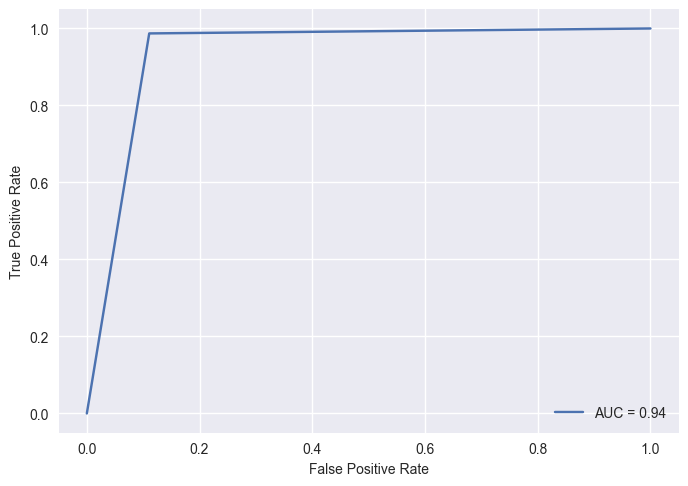

In [44]:
# 6.1 Попробуем KNN с подбором гиперпараметров

parameters = {
    'n_neighbors': np.arange(7, 15, 2)
}

knn_optimal = GridSearchCV(KNeighborsClassifier(), parameters).fit(X_train_class, y_train_class)
y_pred_knn_opt = knn_optimal.predict(X_test_class)

print(classification_report(y_test_class, y_pred_knn_opt))
draw_roc(y_test_class, y_pred_knn_opt)

              precision    recall  f1-score   support

           0       0.97      0.45      0.61      7082
           1       0.64      0.99      0.78      7082

    accuracy                           0.72     14164
   macro avg       0.81      0.72      0.69     14164
weighted avg       0.81      0.72      0.69     14164



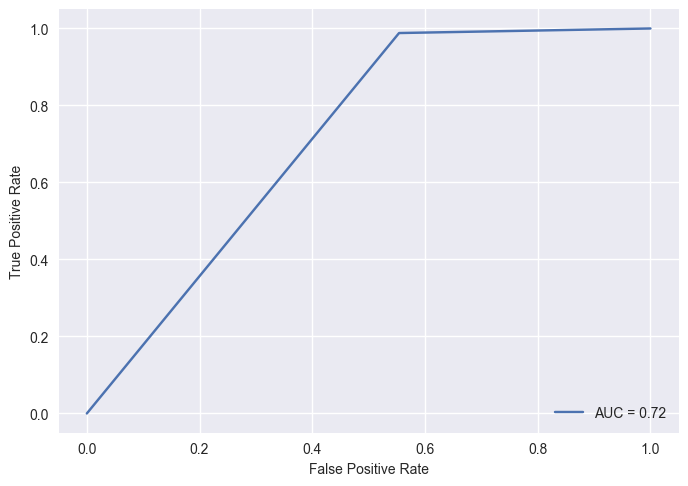

In [45]:
# 6.2 Попробуем наивный Байесовский классификатор

gnb = GaussianNB().fit(X_train_class, y_train_class)
y_pred_gnb_opt = gnb.predict(X_test_class)

print(classification_report(y_test_class, y_pred_gnb_opt))
draw_roc(y_test_class, y_pred_gnb_opt)

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      7082
           1       0.83      0.79      0.81      7082

    accuracy                           0.81     14164
   macro avg       0.81      0.81      0.81     14164
weighted avg       0.81      0.81      0.81     14164



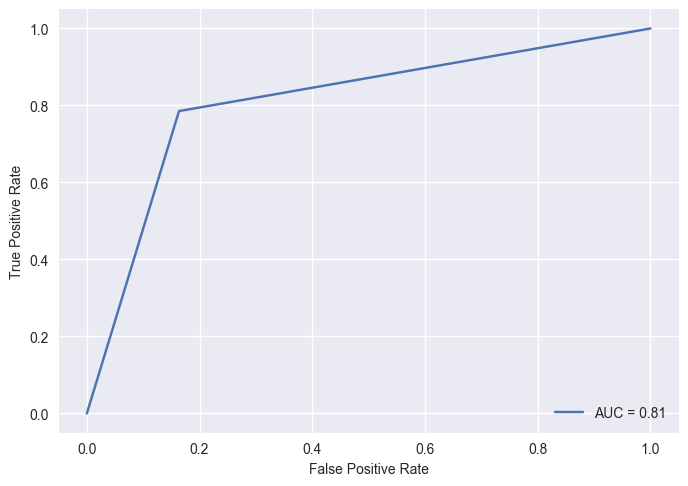

In [46]:
# 6.3 Попробуем логистическую регрессию (с гиперпараметрами)

clf = LogisticRegression(penalty='l1', solver='liblinear').fit(X_train_class, y_train_class)
y_pred_clf = clf.predict(X_test_class)

print(classification_report(y_test_class, y_pred_clf))
draw_roc(y_test_class, y_pred_clf)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7082
           1       0.99      0.99      0.99      7082

    accuracy                           0.99     14164
   macro avg       0.99      0.99      0.99     14164
weighted avg       0.99      0.99      0.99     14164



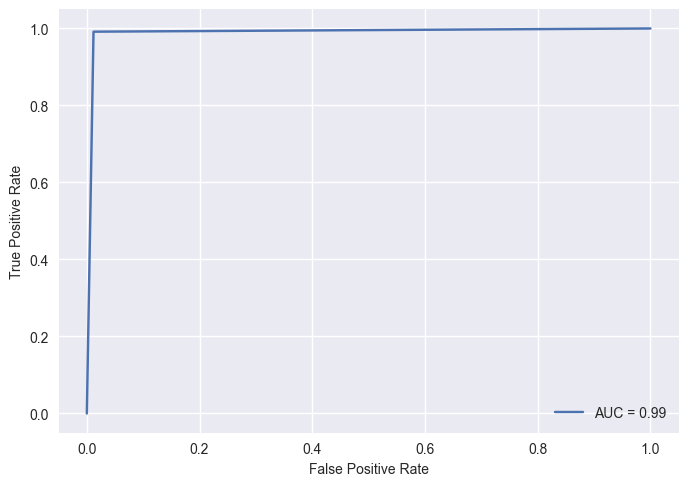

In [47]:
# 6.4 Попробуем решающее дерево с подбором гиперпараметров

parameters = {
    'max_features': np.arange(5, 40, 5),
    'max_depth': np.arange(1, 15, 1)
}

dt_optimal_class = GridSearchCV(DecisionTreeClassifier(), parameters).fit(X_train_class, y_train_class)
y_pred_class_dt_opt = dt_optimal_class.predict(X_test_class)

print(classification_report(y_test_class, y_pred_class_dt_opt))
draw_roc(y_test_class, y_pred_class_dt_opt)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7082
           1       1.00      1.00      1.00      7082

    accuracy                           1.00     14164
   macro avg       1.00      1.00      1.00     14164
weighted avg       1.00      1.00      1.00     14164



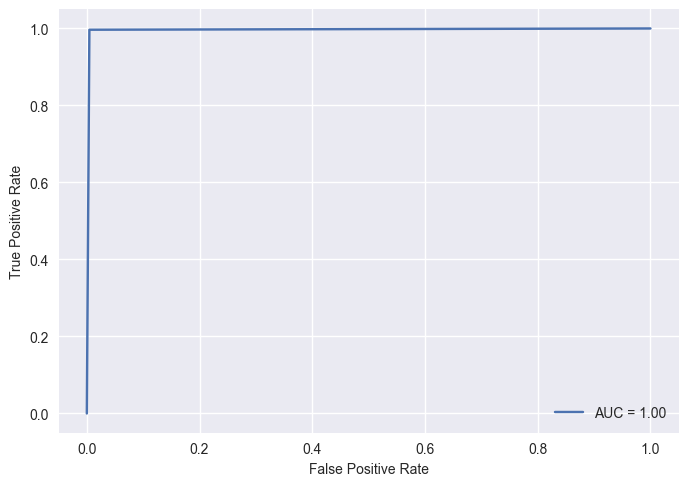

In [48]:
# 6.5 Попробуем бэггинг (ансамбли) с подбором гиперпараметров

parameters = {
    'n_estimators': np.arange(10, 20, 1)
}

bagg_optimal_class = GridSearchCV(BaggingClassifier(), parameters).fit(X_train_class, y_train_class)
y_pred_class_bagg_opt = bagg_optimal_class.predict(X_test_class)

print(classification_report(y_test_class, y_pred_class_bagg_opt))
draw_roc(y_test_class, y_pred_class_bagg_opt)

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      7082
           1       0.88      1.00      0.94      7082

    accuracy                           0.93     14164
   macro avg       0.94      0.93      0.93     14164
weighted avg       0.94      0.93      0.93     14164



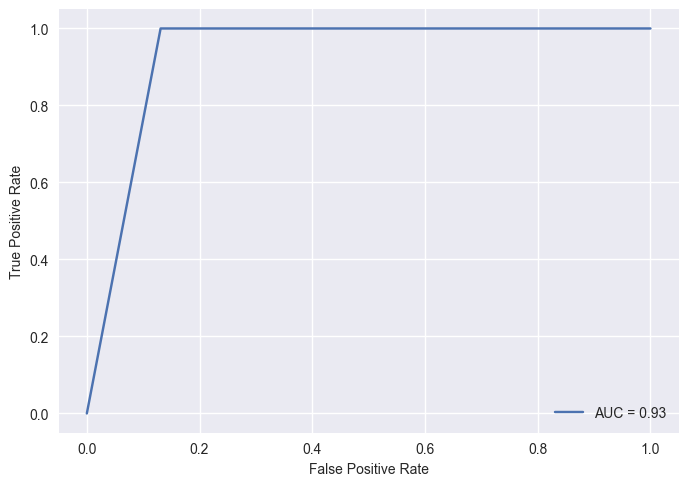

In [49]:
# 6.6 Попробуем градиентный бустинг (ансамбли) с подбором гиперпараметров

boost_optimal_class = GridSearchCV(GradientBoostingClassifier(), parameters).fit(X_train_class, y_train_class)
y_pred_class_boost_opt = boost_optimal_class.predict(X_test_class)

print(classification_report(y_test_class, y_pred_class_boost_opt))
draw_roc(y_test_class, y_pred_class_boost_opt)

# Нейронные сети

In [50]:
# 1. Задача регрессии

model_regression = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(64, activation="relu", input_shape=(33,)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.025),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),

        tf.keras.layers.Dense(1, activation="linear"),
    ]
)

model_regression.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model_regression.fit(X_train_reg, y_train_reg, epochs=50, verbose=None)
y_pred_reg_NN = model_regression.predict(X_test_reg)

27/27 [==============================] - 0s 885us/step


In [51]:
metrics(y_test_reg, y_pred_reg_NN)

MAE: 477.0141778024526
MSE: 71453981.8490257
RMSE: 8453.045714357973
MAPE: 12.030508046833688
R^2: -1941573.385042217


In [52]:
# 2. Задача классификации

model_classification = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(64, activation="relu", input_shape=(19,)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),

        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

model_classification.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy")
model_classification.fit(X_train_class, y_train_class, epochs=25, verbose=None)
y_pred_class_NN = np.around(model_classification.predict(X_test_class))

443/443 [==============================] - 0s 686us/step


              precision    recall  f1-score   support

           0       0.99      0.81      0.89      7082
           1       0.84      0.99      0.91      7082

    accuracy                           0.90     14164
   macro avg       0.91      0.90      0.90     14164
weighted avg       0.91      0.90      0.90     14164



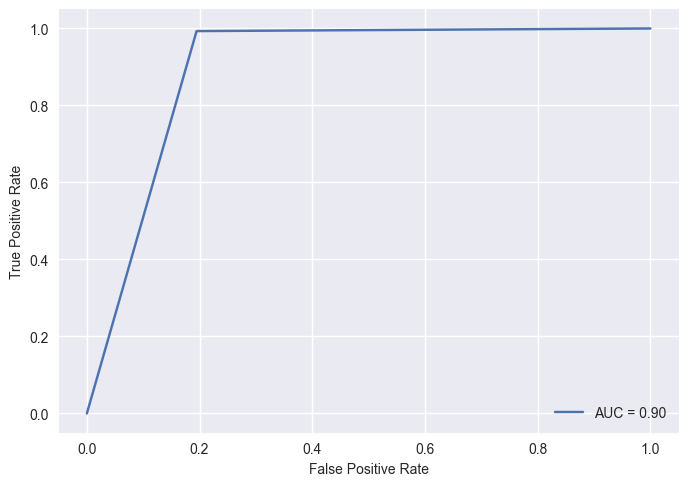

In [53]:
print(classification_report(y_test_class, y_pred_class_NN))
draw_roc(y_test_class, y_pred_class_NN)

# Дополнительные задания

              precision    recall  f1-score   support

           0       0.97      0.79      0.87       981
           1       0.83      0.98      0.89      1019

    accuracy                           0.88      2000
   macro avg       0.90      0.88      0.88      2000
weighted avg       0.90      0.88      0.88      2000



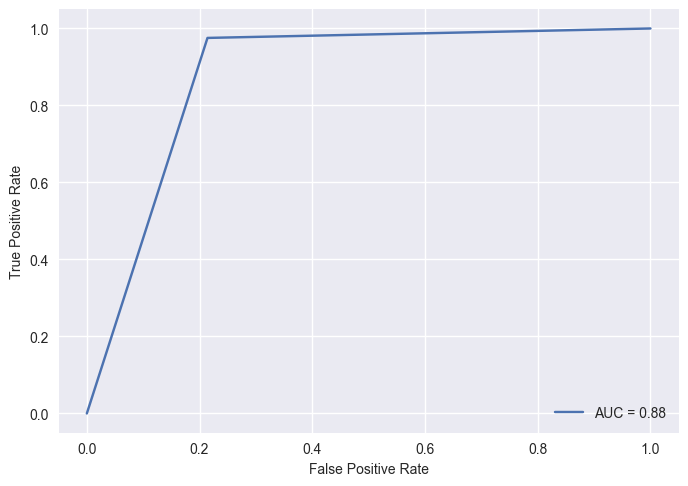

In [54]:
# 1. Решение задачи классификации с помощью собствкенного KNN

from utils.KNN import MyKNN

# Библиотечная версия
knn = KNeighborsClassifier().fit(X_train_class[:2000], y_train_class[:2000])
y_pred = knn.predict(X_test_class[:2000])

print(classification_report(y_test_class[:2000], y_pred))
draw_roc(y_test_class[:2000], y_pred)

c:\Users\bugae\MLGazzzz\utils\KNN.py:35: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  answer.append(np.around(mode(choise)[0][0]))


              precision    recall  f1-score   support

           0       0.96      0.77      0.85       981
           1       0.81      0.97      0.89      1019

    accuracy                           0.87      2000
   macro avg       0.89      0.87      0.87      2000
weighted avg       0.89      0.87      0.87      2000



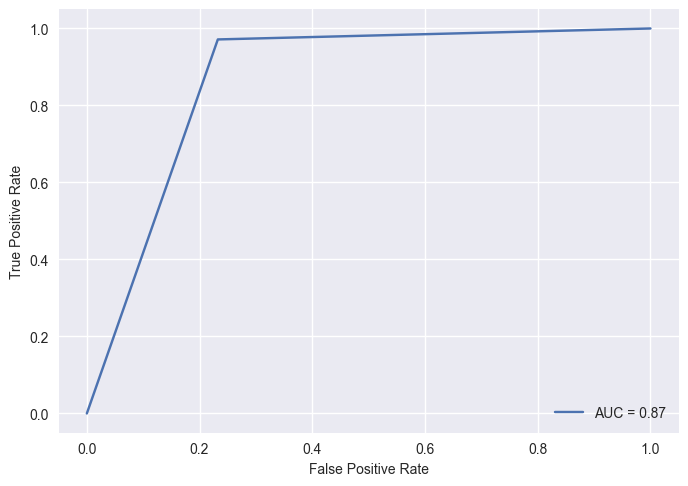

In [55]:
# Своя версия
knn = MyKNN()
knn.fit(X_train_class[:2000], y_train_class[:2000])
y_pred = knn.predict(X_test_class[:2000])

print(classification_report(y_test_class[:2000], y_pred))
draw_roc(y_test_class[:2000], y_pred)

In [56]:
# 2. Градиентный бустинг XGBoost и CatBoost для регрессии и классификации

# 2.1 Градиентный бустинг XGBoost для регрессии

from xgboost import XGBRegressor

xg_reg = XGBRegressor(max_depth=8).fit(X_train_reg, y_train_reg)
y_pred_reg_hg = xg_reg.predict(X_test_reg)

metrics(y_test_reg, y_pred_reg_hg)

MAE: 2.7598496307404767
MSE: 15.570514596047536
RMSE: 3.9459491375393494
MAPE: 0.07614641076630922
R^2: 0.5769121395433603


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7082
           1       1.00      1.00      1.00      7082

    accuracy                           1.00     14164
   macro avg       1.00      1.00      1.00     14164
weighted avg       1.00      1.00      1.00     14164



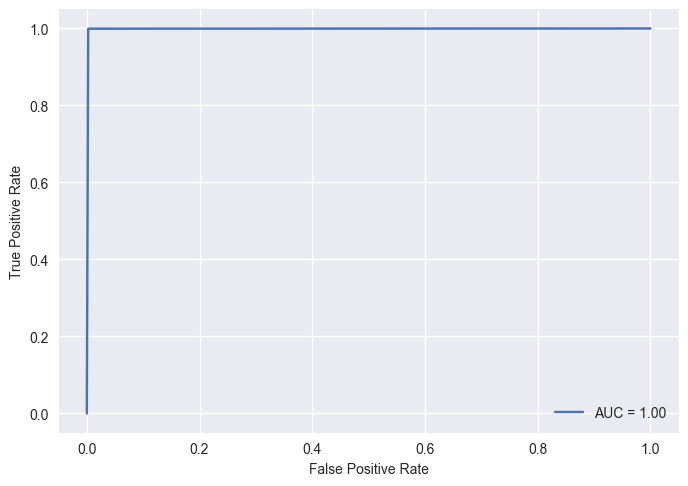

In [57]:
# 2.2 Градиентный бустинг XGBoost для классификации

from xgboost import XGBClassifier

xg_class = XGBClassifier(max_depth=8).fit(X_train_class, y_train_class)
y_pred_class_hg = xg_class.predict(X_test_class)

print(classification_report(y_test_class, y_pred_class_hg))
draw_roc(y_test_class, y_pred_class_hg)

In [58]:
# 2.3 Градиентный бустинг CatBoost для регрессии

from catboost import CatBoostRegressor

cat_reg = CatBoostRegressor(learning_rate=0.03, depth=6, l2_leaf_reg=0.2).fit(X_train_reg, y_train_reg)
y_pred_reg_cat = cat_reg.predict(X_test_reg)

metrics(y_test_reg, y_pred_reg_cat)

0:	learn: 5.4230964	total: 149ms	remaining: 2m 28s
1:	learn: 5.3808402	total: 154ms	remaining: 1m 16s
2:	learn: 5.3464115	total: 157ms	remaining: 52.3s
3:	learn: 5.3037071	total: 161ms	remaining: 40.1s
4:	learn: 5.2620542	total: 164ms	remaining: 32.6s
5:	learn: 5.2254938	total: 166ms	remaining: 27.6s
6:	learn: 5.1947931	total: 169ms	remaining: 24s
7:	learn: 5.1659997	total: 171ms	remaining: 21.2s
8:	learn: 5.1368372	total: 174ms	remaining: 19.1s
9:	learn: 5.1040005	total: 175ms	remaining: 17.4s
10:	learn: 5.0710422	total: 177ms	remaining: 15.9s
11:	learn: 5.0336581	total: 178ms	remaining: 14.7s
12:	learn: 5.0084481	total: 180ms	remaining: 13.6s
13:	learn: 4.9882910	total: 181ms	remaining: 12.8s
14:	learn: 4.9636538	total: 182ms	remaining: 12s
15:	learn: 4.9430001	total: 184ms	remaining: 11.3s
16:	learn: 4.9208733	total: 185ms	remaining: 10.7s
17:	learn: 4.9022358	total: 186ms	remaining: 10.2s
18:	learn: 4.8775148	total: 187ms	remaining: 9.68s
19:	learn: 4.8607675	total: 189ms	remaining

0:	learn: 0.6284428	total: 6.22ms	remaining: 6.21s
1:	learn: 0.5688945	total: 12.1ms	remaining: 6.02s
2:	learn: 0.5195641	total: 17.8ms	remaining: 5.91s
3:	learn: 0.4730888	total: 23.9ms	remaining: 5.95s
4:	learn: 0.4371281	total: 30.2ms	remaining: 6s
5:	learn: 0.4065785	total: 34.9ms	remaining: 5.78s
6:	learn: 0.3860288	total: 40.2ms	remaining: 5.7s
7:	learn: 0.3622783	total: 45.1ms	remaining: 5.59s
8:	learn: 0.3397798	total: 49.8ms	remaining: 5.48s
9:	learn: 0.3210729	total: 54.5ms	remaining: 5.4s
10:	learn: 0.3030345	total: 59.7ms	remaining: 5.37s
11:	learn: 0.2868986	total: 64.3ms	remaining: 5.29s
12:	learn: 0.2730493	total: 68.9ms	remaining: 5.23s
13:	learn: 0.2623826	total: 74.5ms	remaining: 5.25s
14:	learn: 0.2484036	total: 80.5ms	remaining: 5.29s
15:	learn: 0.2384882	total: 86.3ms	remaining: 5.31s
16:	learn: 0.2280184	total: 92.5ms	remaining: 5.35s
17:	learn: 0.2198709	total: 97.3ms	remaining: 5.31s
18:	learn: 0.2113470	total: 102ms	remaining: 5.25s
19:	learn: 0.2034041	total: 

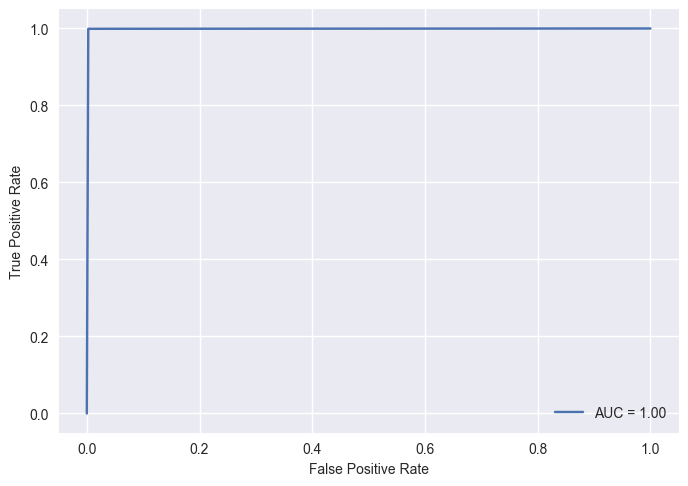

In [59]:
# 2.4 Градиентный бустинг CatBoost для классификации

from catboost import CatBoostClassifier

cat_class = CatBoostClassifier(learning_rate=0.03, depth=6, l2_leaf_reg=0.2).fit(X_train_class, y_train_class)
y_pred_class_cat = cat_class.predict(X_test_class)

print(classification_report(y_test_class, y_pred_class_cat))
draw_roc(y_test_class, y_pred_class_cat)